In [1]:
%load_ext autoreload

In [13]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from functools import partial
from tqdm.auto import tqdm
from jax.experimental.optimizers import adam, momentum
import jax.scipy.stats as stats
import jax.experimental.stax as stax
from jx.utils import progress_bar_scan
from jax.config import config
config.update("jax_enable_x64", True)

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['figure.figsize'] = (11, 7)

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
def noise(key, dt):
    return jax.random.normal(key) * jnp.sqrt(dt)

# SDE methods

In [5]:
@jax.jit
def lerp(t0, t1, y0, y1, t):
    return (y0 * (t1 - t) + y1 * (t - t0)) / (t1 - t0)

In [73]:
@partial(jax.jit, static_argnums=(0, 1, 3))
def _sdeint_step_euler(drift, diffusion, params, aug_fn, y, t0, t1, key):
    dt = t1 - t0
    
    dft = drift(y, t0, params)
    dfn = diffusion(y, t0, params)
    dW = noise(key, dt)
    
    y = y + dft * dt + dfn * dW
    
    if aug_fn:
        aug = aug_fn(y, t0, params)
    else:
        aug = None
    
    return y, (y, aug)

@partial(jax.jit, static_argnums=(0, 1, 3))
def _sdeint_step_milstein(drift, diffusion, params, aug_fn, y, t0, t1, key):
    dt = t1 - t0
    
    dft = drift(y, t0, params)
    dfn = diffusion(y, t0, params)
    dfn_grad = jax.grad(diffusion)(y, t0, params)
    dW = noise(key, dt)
    
    y = y + dft * dt + dfn * dW + 0.5 * dfn * dfn_grad * (dW**2 - dt)
    
    if aug_fn:
        aug = aug_fn(y, t0, params)
    else:
        aug = None
    
    return y, (y, aug)

def _sdeint(drift, diffusion, y0, t, params, key, dt, maxiter, sdeint_step, aug_fn=None, method='milstein'):

    @jax.jit
    def step_once(carry):
        t_prev, t_curr, t_obs, y_prev, y_curr, aug, key = carry
        t_next = jnp.minimum(t_curr + dt, t[-1])
        t_prev, y_prev = t_curr, y_curr
        key, subkey = jax.random.split(key)
        _, y_aug = sdeint_step(
            drift,
            diffusion, 
            params, 
            None if aug_fn is None else aug_fn, 
            y_curr, 
            t_curr,
            t_next,
            subkey
        )
        y_curr, aug = y_aug
        t_curr = t_next
        carry = (t_prev, t_curr, t_obs, y_prev, y_curr, aug, key)
        return carry, None

    def no_op(carry):
        return carry, None

    @jax.jit
    def body_inner(carry, x):
        return jax.lax.cond(carry[1] < carry[2], step_once, no_op, carry)

    @jax.jit
    def body_outer(carry, x):
        t_prev, t_curr, _, y_prev, y_curr, aug_fn, key = carry
        t_obs = x
        carry = t_prev, t_curr, t_obs, y_prev, y_curr, aug_fn, key
        carry, _ = jax.lax.scan(
            body_inner, 
            carry, 
            None, 
            length=maxiter
        )
        t_prev, t_curr, t_obs, y_prev, y_curr, aug, key = carry
        y_store = lerp(t_prev, t_curr, y_prev, y_curr, t_obs)
        return carry, (y_store, aug)
    
    t_prev = t_curr = t[0]
    y_prev = y_curr = y0
    ys = jnp.array([y0])
    augs = jnp.array([0.]) # fix this
    
    carry = (t_prev, t_curr, 0., y_prev, y_curr, 0. if aug_fn else None, key)
    
    _, y_aug = jax.lax.scan(body_outer, carry, t[1:])
        
    ys = jnp.concatenate((ys, y_aug[0]))
    
    if y_aug[1] is None:
        return ys, None
    else:
        augs = jnp.concatenate((augs, y_aug[1]))
        return ys, augs

def sdeint_maker(sde, y0, t, batch=False, dt=0.1, method='milstein'):
    
    has_aug = 'aug' in sde.keys()
    maxiter = jnp.round(jnp.max(jnp.diff(t) / dt)).astype(int).item()
    
    if method == 'euler':
        _sdeint_step = _sdeint_step_euler
    elif method == 'milstein':
        _sdeint_step = _sdeint_step_milstein
    else:
        raise

    res = partial(
        _sdeint, 
        drift=sde['drift'], 
        diffusion=sde['diffusion'],
        y0=y0,
        dt=dt,
        maxiter=maxiter,
        sdeint_step=_sdeint_step,
        aug_fn=sde['aug'] if has_aug else None,
        method=method
    )
    
    res2 = lambda t, params, key: res(t=t, params=params, key=key)
    
    if batch:
        return jax.vmap(res2, in_axes=(None, None, 0))
    else:
        return res2

# Make an Ornstein-Uhlenbeck process

In [74]:
# define the SDE
ou = dict(
    drift = lambda y, t, p: p['theta'] * (p['mu'] - y),
    diffusion = lambda y, t, p: jnp.exp(p['sigma'])
)

# create some initial parameters for the SDE
params = dict(
    theta=1.,
    mu=1.,
    sigma=-2.,
)

CPU times: user 730 ms, sys: 1.02 ms, total: 731 ms
Wall time: 188 ms
CPU times: user 910 ms, sys: 10.1 ms, total: 920 ms
Wall time: 377 ms


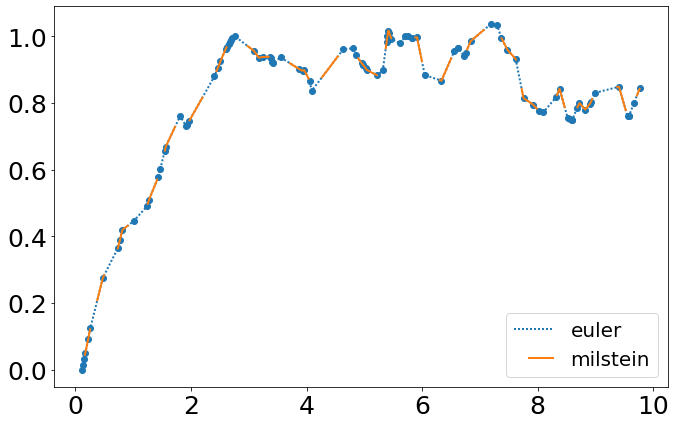

In [75]:
# run sdeint with two different integrators
x = jnp.sort(jax.random.uniform(key, minval=0., maxval=10., shape=(100,)))
sdeint = sdeint_maker(ou, 0., x, batch=False)
for m, ls in zip(['euler', 'milstein'], [(1, 1, 1), (0, 7, 7)]):
    %time y = sdeint(t=x, params=params, key=key)[0]
    plt.plot(x, y, label=m, dashes=ls, lw=2)
plt.legend(fontsize=20)
plt.scatter(x, y)

# define MSE loss function and its gradient

In [34]:
run_sde = lambda p, k: sdeint(t=x, params=p, key=k)[0]
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

# fit to data to get best SDE parameters 

In [35]:
opt_init, opt_update, get_params = momentum(1e-4, 0.9)
opt_state = opt_init(params)

niter = 100
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

params = get_params(opt_state)

  0%|          | 0/100 [00:00<?, ?it/s]

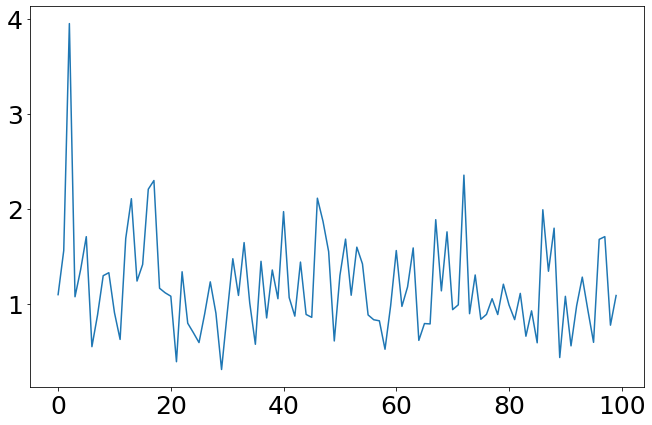

In [29]:
plt.plot(losses)

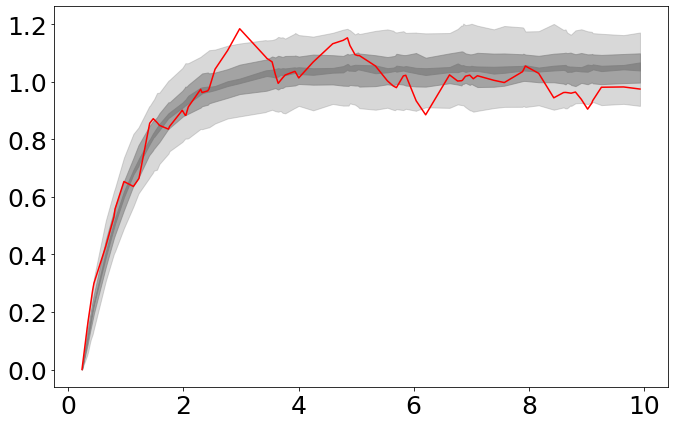

In [30]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

# Replace drift and diffusion terms with neural networks 

In [37]:
drift_init, drift_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

diffusion_init, diffusion_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

# make SDE

In [57]:
sde_nn = dict(
    drift = jax.jit(lambda y, t, p: drift_apply(p['drift'], y)[0][0]),
    diffusion = jax.jit(lambda y, t, p: diffusion_apply(p['diffusion'], y)[0][0])
)

# define loss

In [65]:
sdeint = sdeint_maker(sde=sde_nn, y0=y[0], t=x, method='euler', batch=False)
run_sde = jax.jit(lambda p, k: sdeint(x, p, k)[0])
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

# initialize SDE/network parameters

In [63]:
key, k1, k2 = jax.random.split(key, 3)
_, p_drift_init = drift_init(k1, (1,))
out_shape, p_diffusion_init = diffusion_init(k2, (1,))
nn_params = dict(
    drift = p_drift_init,
    diffusion = p_diffusion_init,
)

# optimize SDE/neural network parameters

In [45]:
opt_init, opt_update, get_params = adam(1e-2)
opt_state = opt_init(nn_params)

niter = 200
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

nn_params = get_params(opt_state)

  0%|          | 0/200 [00:00<?, ?it/s]

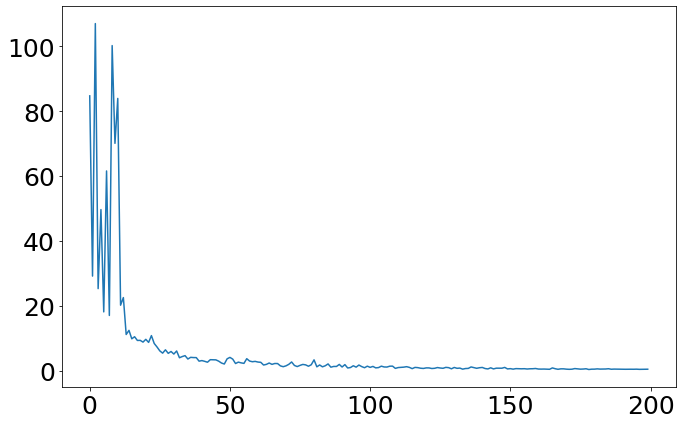

In [46]:
plt.plot(losses)

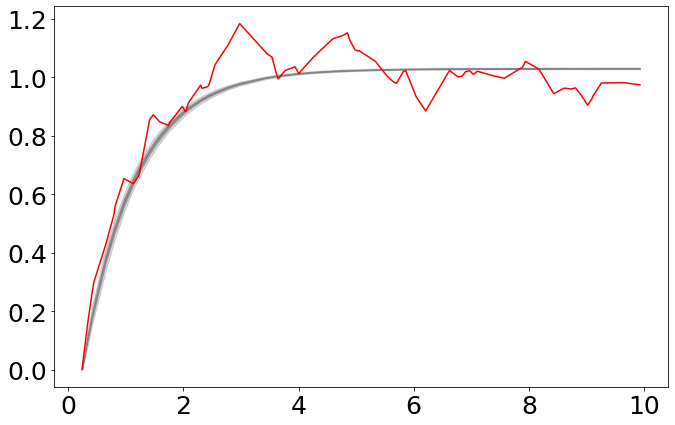

In [47]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(nn_params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

# diffusion term seems to go to 0, need to regularize

# 
-----------
#

# adapted from torchsde latent_sde.py example

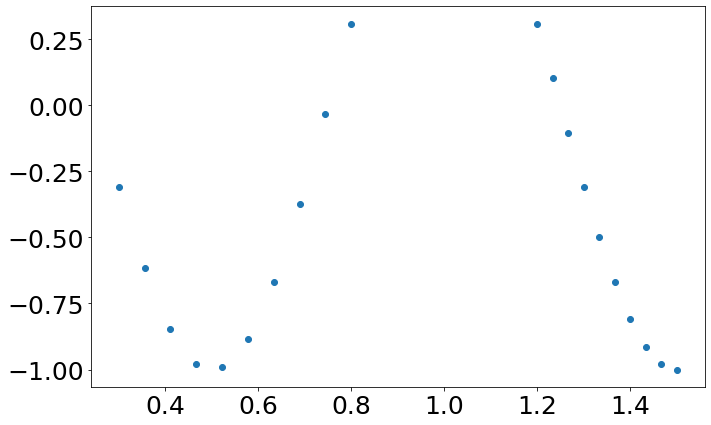

In [124]:
x = jnp.concatenate((jnp.linspace(0.3, 0.8, 10), jnp.linspace(1.2, 1.5, 10)), axis=0)
y = jnp.cos(x * (2. * jnp.pi))
plt.scatter(x, y)

In [125]:
def f(y, t, p): 
    inp = jnp.array((jnp.sin(t), jnp.cos(t), y))
    return drift_apply(p['drift'], inp)[0]

In [126]:
def g(y, t, p):
    # return diffusion_apply(p['diffusion'], y)[0][0]
    return jnp.exp(p['sigma'])

In [127]:
def h(y, t, p):
    return p['theta'] * (p['mu'] - y)

In [128]:
def aug_fn(y, t, p):
    f_out, g_out, h_out = f(t, y, p), g(t, y, p), h(t, y, p)
    u = (f_out - h_out) / g_out
    logqp = 0.5 * u**2
    return logqp

In [129]:
drift_init, drift_apply = stax.serial(
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(1),
)

diffusion_init, diffusion_apply = stax.serial(
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(1),
)

In [130]:
key, k1, k2 = jax.random.split(key, 3)
_, p_drift_init = drift_init(k1, (3,))
out_shape, p_diffusion_init = diffusion_init(k2, (1,))

params = dict(
    drift = p_drift_init,
    diffusion = p_diffusion_init,
    sigma = 0.,
    theta = 0.,
    mu = 0.,
)

In [131]:
sde = dict(
    drift = f,
    diffusion = g,
    aug = aug_fn,
)
sdeint = sdeint_maker(sde=sde, y0=y[0], t=x, batch=True, method='euler')

In [132]:
@jax.jit
def loss_fn(params, keys):
    ys, logqps = sdeint(x, params, keys)
    logpy = stats.laplace.logpdf(ys, loc=y, scale=0.05).sum(axis=-1).mean()
    kl = logqps.sum(axis=-1).mean()
    loss = -logpy + kl
    return loss

loss_vg = jax.jit(jax.value_and_grad(loss_fn))

In [133]:
opt_init, opt_update, get_params = adam(1e-2)
opt_state = opt_init(params)
losses = []

In [137]:
niter = 1000
batch_size = 512

keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    keys = jax.random.split(key, batch_size)
    loss, grad = loss_vg(get_params(opt_state), keys)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    if i % 5 == 0:
        pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

# pbar = progress_bar_scan(niter)
# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

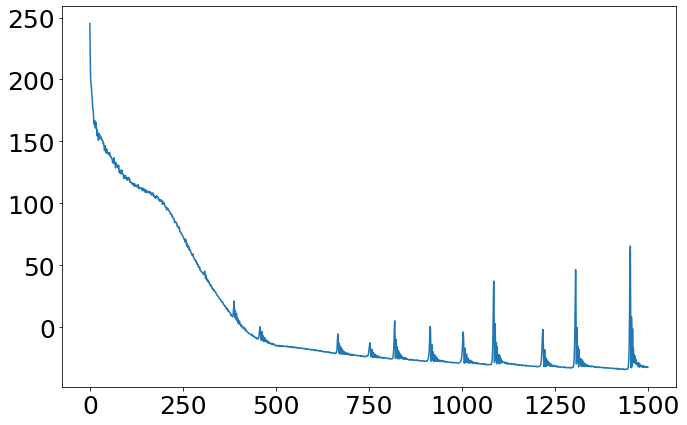

In [138]:
plt.plot(losses)

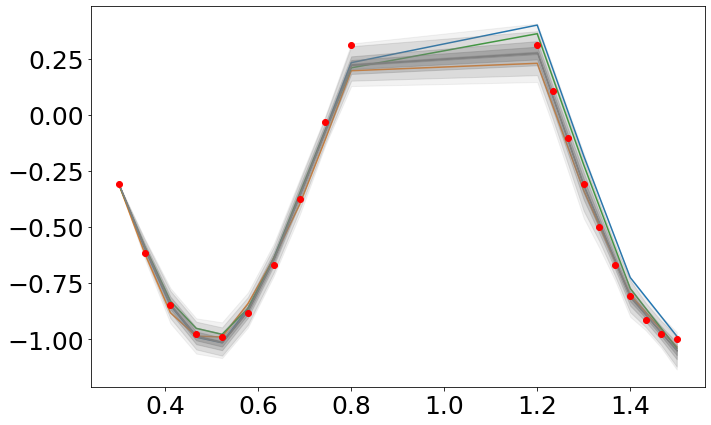

In [147]:
ys, _ = sdeint(x, params, keys)
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 1.]
percentiles = [0.999, 0.99, 0.9, 0.75, 0.55, 0.5]
for a, p in zip(alphas, percentiles):
    plt.fill_between(x, *jnp.quantile(ys, jnp.array([1. - p, p]), axis=0), alpha=a, color='gray')
plt.scatter(x, y, c='r')
for i in range(3):
    plt.plot(x, ys[i], zorder=-1)